In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from scipy.sparse import coo_matrix

In [2]:
trainData = pd.read_csv('data/marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv', sep='\t')
trainData.shape

(5000, 32)

In [3]:
trainData.columns

Index(['Uniq Id', 'Crawl Timestamp', 'Dataset Origin', 'Product Id',
       'Product Barcode', 'Product Company Type Source',
       'Product Brand Source', 'Product Brand Normalised Source',
       'Product Name Source', 'Match Rank', 'Match Score', 'Match Type',
       'Retailer', 'Product Category', 'Product Brand', 'Product Name',
       'Product Price', 'Sku', 'Upc', 'Product Url', 'Market',
       'Product Description', 'Product Currency',
       'Product Available Inventory', 'Product Image Url',
       'Product Model Number', 'Product Tags', 'Product Contents',
       'Product Rating', 'Product Reviews Count', 'Bsr', 'Joining Key'],
      dtype='object')

In [4]:
trainData = trainData[['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count', 'Product Category', 'Product Brand', 'Product Name', 'Product Image Url', 'Product Description', 'Product Tags']]
trainData.head()

,Uniq Id,Product Id,Product Rating,Product Reviews Count,Product Category,Product Brand,Product Name,Product Image Url,Product Description,Product Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,NaN,NaN,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,NaN,NaN,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...
3,fddc4df45b35efd886794b261f730c51,03b5fb878a33eadff8b033419eab9669,NaN,NaN,Beauty > Makeup > Lip,Kokie Cosmetics,"Kokie Professional Matte Lipstick, Hot Berry, ...",https://i5.walmartimages.com/asr/25b4b467-bc61...,Calling all matte lip lovers! Indulge in our r...,"Kokie Professional Matte Lipstick, Hot Berry, ..."
4,0990cf89a59ca6a0460349a3e4f51d42,ce3d761e57d6ccad80619297b5b1bcbc,NaN,131.0,Seasonal > Stock Up Essentials > Personal Care...,Gillette,"Gillette TRAC II Plus Razor Blade Refills, Fit...",https://i5.walmartimages.com/asr/1a2ebb06-cd01...,"In 1971, Gillette introduced the Trac II razor...","Gillette TRAC II Plus Razor Blade Refills, Fit..."


In [5]:
trainData.shape

(5000, 10)

In [6]:
trainData.isnull().sum()

Uniq Id                     0
Product Id                  0
Product Rating           2806
Product Reviews Count    1654
Product Category           10
Product Brand              13
Product Name                0
Product Image Url           0
Product Description      1127
Product Tags                0
dtype: int64

In [7]:
trainData['Product Rating'] = trainData['Product Rating'].fillna(0)
trainData['Product Reviews Count'] = trainData['Product Reviews Count'].fillna(0)
trainData['Product Category'] = trainData['Product Category'].fillna('')
trainData['Product Brand'] = trainData['Product Brand'].fillna('')
trainData['Product Description'] = trainData['Product Description'].fillna('')

In [8]:
trainData.isnull().sum()

Uniq Id                  0
Product Id               0
Product Rating           0
Product Reviews Count    0
Product Category         0
Product Brand            0
Product Name             0
Product Image Url        0
Product Description      0
Product Tags             0
dtype: int64

In [9]:
print(trainData.duplicated().sum())

0


In [10]:
trainData.columns

Index(['Uniq Id', 'Product Id', 'Product Rating', 'Product Reviews Count',
       'Product Category', 'Product Brand', 'Product Name',
       'Product Image Url', 'Product Description', 'Product Tags'],
      dtype='object')

In [11]:
columnNameMapping = {
    'Uniq Id': 'ID',
    'Product Id': 'prodID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'reviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'imageURL', 
    'Product Description': 'Description', 
    'Product Tags': 'Tags'
}

trainData.rename(columns=columnNameMapping, inplace=True)

In [12]:
trainData.columns

Index(['ID', 'prodID', 'Rating', 'reviewCount', 'Category', 'Brand', 'Name',
       'imageURL', 'Description', 'Tags'],
      dtype='object')

In [13]:
trainData.head(3)

,ID,prodID,Rating,reviewCount,Category,Brand,Name,imageURL,Description,Tags
0,1705736792d82aa2f2d3caf1c07c53f4,2e17bf4acecdece67fc00f07ad62c910,0.0,0.0,Premium Beauty > Premium Makeup > Premium Nail...,OPI,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"OPI Infinite Shine, Nail Lacquer Nail Polish, ..."
1,95a9fe6f4810fcfc7ff244fd06784f11,076e5854a62dd283c253d6bae415af1f,0.0,0.0,Beauty > Hair Care > Hair Color > Auburn Hair ...,Nice'n Easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,Pack of 3 Pack of 3 for the UPC: 381519000201 ...,"Nice 'n Easy Permanent Color, 111 Natural Medi..."
2,8d4d0330178d3ed181b15a4102b287f2,8a4fe5d9c7a6ed26cc44d785a454b124,4.5,29221.0,Beauty > Hair Care > Hair Color > Permanent Ha...,Clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,This Clairol Nice N Easy Permanent Color gives...,Clairol Nice 'N Easy Permanent Color 7/106A Na...


In [14]:
trainData['ID'] = trainData['ID'].str.extract(r'(\d+)').astype(float)
trainData['prodID'] = trainData['prodID'].str.extract(r'(\d+)').astype(float)

In [15]:
numUsers = trainData['ID'].nunique()
numItems = trainData['prodID'].nunique()
numRatings = trainData['Rating'].nunique()
print(f"Number of unique users: {numUsers}")
print(f"Number of unique items: {numItems}")
print(f"Number of unique ratings: {numRatings}")

Number of unique users: 1721
Number of unique items: 1697
Number of unique ratings: 36


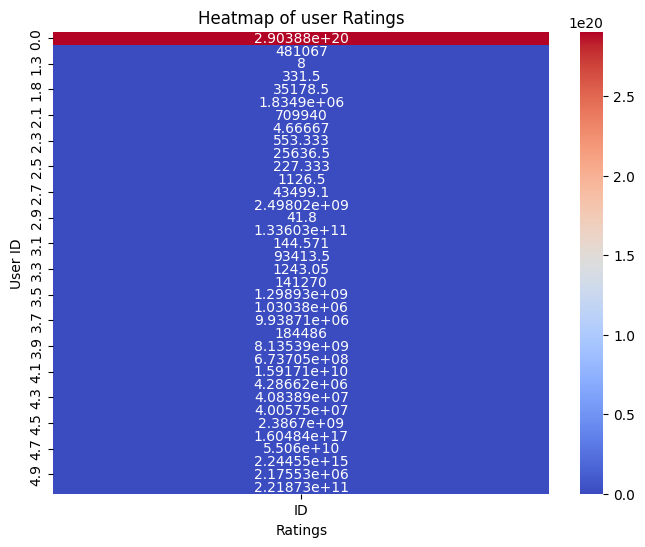

In [16]:
heatmapData = trainData.pivot_table('ID', 'Rating')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmapData, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of user Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

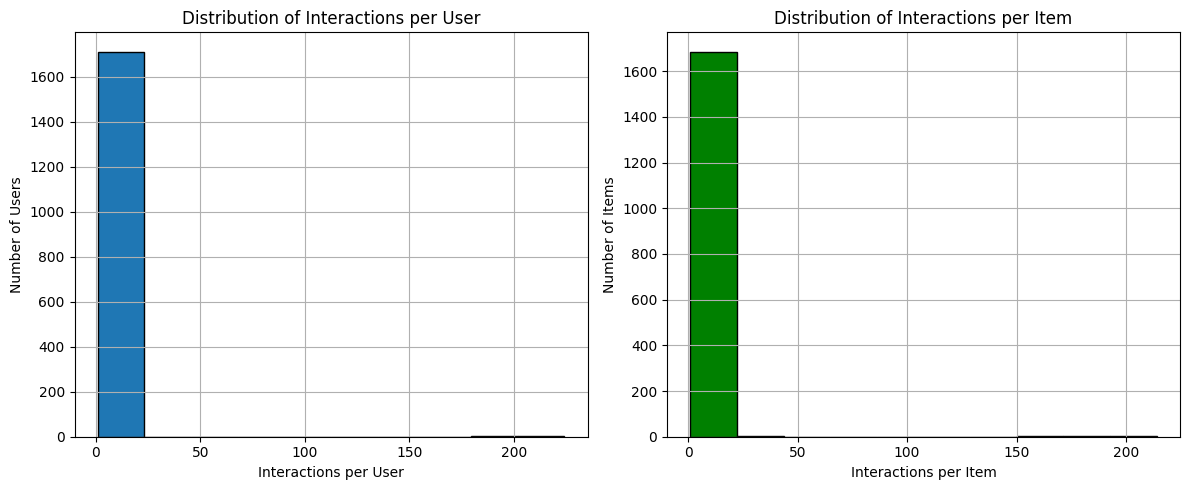

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
trainData['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
trainData['prodID'].value_counts().hist(bins=10, edgecolor='k', color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular Items')

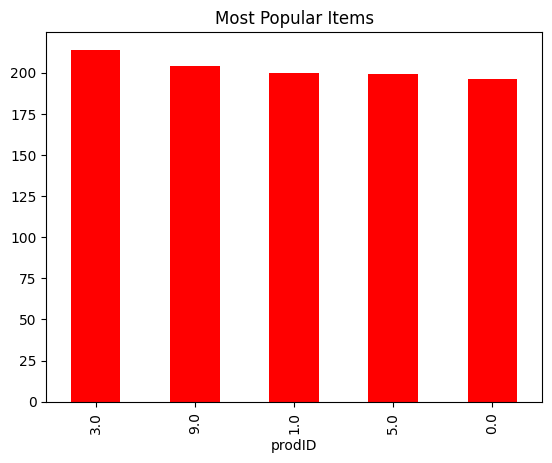

In [18]:
popularItems = trainData['prodID'].value_counts().head(5)
popularItems.plot(kind='bar', color='red')
plt.title("Most Popular Items")

<Axes: xlabel='Rating'>

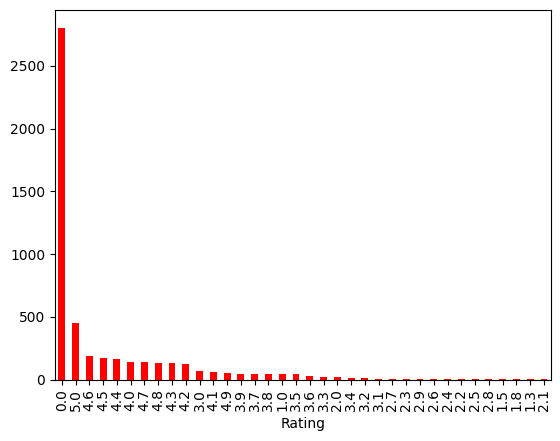

In [19]:
trainData['Rating'].value_counts().plot(kind='bar', color='red')

In [20]:
trainData['Tags']

0       OPI Infinite Shine, Nail Lacquer Nail Polish, ...
1       Nice 'n Easy Permanent Color, 111 Natural Medi...
2       Clairol Nice 'N Easy Permanent Color 7/106A Na...
3       Kokie Professional Matte Lipstick, Hot Berry, ...
4       Gillette TRAC II Plus Razor Blade Refills, Fit...
                              ...                        
4995    Garden Mint Room Spray (Double Strength), 4 ou...
4996    Garnier Nutrisse Nourishing Hair Color Creme (...
4997    Nail File Electric Drill, 6 in 1 Professional ...
4998    Creed Love In Black Hair And Body Wash 6.8oz/2...
4999                    Foundation, Wal-mart, Walmart.com
Name: Tags, Length: 5000, dtype: object

In [21]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    trainData[column] = trainData[column].apply(clean_and_extract_tags)

In [22]:
trainData['Tags'] = trainData[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

In [23]:
trainData['Tags']

0       premium, beauty, premium, makeup, premium, nai...
1       beauty, hair, care, hair, color, auburn, hair,...
2       beauty, hair, care, hair, color, permanent, ha...
3       beauty, makeup, lip, kokie, cosmetics, calling...
4       seasonal, stock, essentials, personal, care, s...
                              ...                        
4995    household, essentials, air, fresheners, spray,...
4996    beauty, hair, care, hair, color, permanent, ha...
4997    beauty, makeup, nails, stoneway, multifunction...
4998    premium, beauty, premium, bath, body, premium,...
4999    beauty, makeup, face, makeup, face, makeup, br...
Name: Tags, Length: 5000, dtype: object

### Rating Based Recommendations System

In [24]:
trainData.head(2)

,ID,prodID,Rating,reviewCount,Category,Brand,Name,imageURL,Description,Tags
0,1.705737e+09,2.0,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,,"premium, beauty, premium, makeup, premium, nai..."
1,9.500000e+01,76.0,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."


In [25]:
avgRatings = trainData.groupby(['Name', 'reviewCount', 'Brand', 'imageURL'])['Rating'].mean().reset_index()

In [26]:
topRatedItems = avgRatings.sort_values(by='Rating', ascending=False)
ratingBasedRecommendation = topRatedItems.head(10)

In [27]:
ratingBasedRecommendation.loc[:, 'Rating'] = ratingBasedRecommendation['Rating'].astype(int)
ratingBasedRecommendation.loc[:, 'reviewCount'] = ratingBasedRecommendation['reviewCount'].astype(int)

In [28]:
ratingBasedRecommendation.head()

,Name,reviewCount,Brand,imageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
1208,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0


In [29]:
print("Rating Based Recommedation System: (Trending Products)")
ratingBasedRecommendation

Rating Based Recommedation System: (Trending Products)


,Name,reviewCount,Brand,imageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
4959,got2b Kinkier Curling Mousse 8 oz (Pack of 2),1.0,göt2b,https://i5.walmartimages.com/asr/9e656b95-79f6...,5.0
6,($14 Value) Burts Bees Beeswax Bounty Classic ...,10.0,"burt, bees",https://i5.walmartimages.com/asr/bfbb58dc-8199...,5.0
1208,Clairol Professional Beautiful Collection Semi...,1.0,clairol,https://i5.walmartimages.com/asr/31562542-b683...,5.0
1216,"Clairol Textures & Tones 4RC Cherrywood, 1 ea ...",1.0,clairol,https://i5.walmartimages.com/asr/78f33717-0104...,5.0
1228,Clay-Park Labs Ammonium Lactate Lotion 12% 14 ...,13.0,"clay, park, labs",https://i5.walmartimages.com/asr/b3d5462d-d067...,5.0
4857,"Yosoo Reusable Sanitary Pads with Wings, 9 Typ...",1.0,yosoo,https://i5.walmartimages.com/asr/5645ee43-e26f...,5.0
4862,ZINSSER & CO Jomax 1-Qt. Mold & Mildew Stain R...,1.0,jomax,https://i5.walmartimages.com/asr/d04c8d61-023a...,5.0
4892,"all Free Clear For Sensitive Skin, 110 Loads, ...",4.0,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5.0
33,($55 Value) Clarins Multi-Active Day Face Crea...,2.0,clarins,https://i5.walmartimages.com/asr/894b62ab-76d2...,5.0
